In [3]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import fitsio
from astrometry.util.fits import fits_table, merge_tables
from glob import glob

from sklearn import mixture

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from obiwan.common import fits2pandas

In [5]:
def stack_tables(fns):
    cat=[]
    assert(len(fns) > 0)
    for fn in fns:
        assert(os.path.exists(fn))
        print('Stacking %s' % fn)
        cat.append( fits_table(fn) )
    return merge_tables(cat, columns='fillzero')

def flux2mag(nmgy):
    return -2.5 * (np.log10(nmgy) - 9)


In [6]:
def get_xy_pad(slope,pad):
    """Returns dx,dy"""
    theta= np.arctan(abs(slope))
    return pad*np.sin(theta), pad*np.cos(theta)

def y1_line(rz,pad=None):
    slope,yint= 1.15,-0.15
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz+dx) + yint + dy
    else:
        return slope*rz + yint
    
def y2_line(rz,pad=None):
    slope,yint= -1.2,1.6
    if pad: 
        dx,dy= get_xy_pad(slope,pad)
        return slope*(rz-dx) + yint + dy
    else:
        return slope*rz + yint

def get_ELG_box(rz,gr, pad=None):
    """
    Args:
        rz: r-z
        gr: g-r
        pad: magnitudes of padding to expand TS box
    """
    x1,y1= rz,y1_line(rz)
    x2,y2= rz,y2_line(rz)
    x3,y3= np.array([0.3]*len(rz)),gr
    x4,y4= np.array([1.6]*len(rz)),gr
    if pad:
        dx,dy= get_xy_pad(1.15,pad)
        x1,y1= x1-dx,y1+dy
        dx,dy= get_xy_pad(-1.2,pad)
        x2,y2= x2+dx,y2+dy
        x3 -= pad
        x4 += pad
    return dict(x1=x1, y1=y1,
                x2=x2, y2=y2,
                x3=x3, y3=y3,
                x4=x4, y4=y4)

In [7]:
def my_mixture(X,n_comp=None,cov_type='full'):
    # Compute density via Gaussian Mixtures
    # we'll try several numbers of clusters
    if n_comp is None:
        n_comp = np.arange(3, 16)
    gmms = [mixture.GaussianMixture(n_components=n,
                                    covariance_type= cov_type).fit(X) 
            for n in n_comp]
    BICs = [gmm.bic(X)/X.shape[0] for gmm in gmms]
    i_min = np.argmin(BICs)
    print("%d components" % n_comp[i_min])
    return gmms,i_min, n_comp, BICs

# eBOSS

In [94]:
a=fits_table(os.path.join(os.environ['HOME'],'Downloads',
                          'ebossDR3','eBOSS.ELG.obiwan.eboss21.v5_10_4.fits'))
len(a)

Converted brickname from |S8 to <U8
Converted type from |S4 to <U4


27126

In [95]:
isStar= a.z_flag == -1
hasRedshift= a.z_flag == 1
isPrim= a.brick_primary == True
print('hasRedshift & brick primary: %d/%d' % \
     (len(a[(hasRedshift) & (isPrim)]),len(a)))

hasRedshift & brick primary: 22197/27126


In [96]:
pd.Series(a.type[isStar]).value_counts(), pd.Series(a.type[hasRedshift]).value_counts(), 

(EXP     87
 DEV     52
 SIMP    10
 PSF     10
 COMP     8
 dtype: int64, EXP     13981
 SIMP     5206
 DEV      1995
 COMP      527
 PSF       488
 dtype: int64)

In [97]:
a.brick_primary == True, hasRedshift

(array([ True,  True,  True, ...,  True,  True,  True], dtype=bool),
 array([ True,  True, False, ..., False,  True,  True], dtype=bool))

In [98]:
d={}
for i,b in zip([1,2,4],'grz'):
    d[b+'flux']= a.get('decam_flux')[:,i]
    d[b+'fluxivar']= a.get('decam_flux_ivar')[:,i]
    d[b+'psfsize']= a.get('decam_psfsize')[:,i]
    d[b+'_mw_transmission']= a.get('decam_mw_transmission')[:,i]
d['type']= a.type
d['shapeexp_r']= a.shapeexp_r
d['shapedev_r']= a.shapedev_r

d['redshift']= a.z

df= pd.DataFrame(d)
df= df.apply(lambda x: x.values.byteswap().newbyteorder())
df= df[(hasRedshift) &
       (a.brick_primary == True)]


for i,b in zip([1,2,4],'grz'):
    df[b]= flux2mag(df[b+'flux'].values/df[b+'_mw_transmission'].values)
df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

df.describe()

,g_mw_transmission,gflux,gfluxivar,gpsfsize,r_mw_transmission,redshift,rflux,rfluxivar,rpsfsize,shapedev_r,shapeexp_r,z_mw_transmission,zflux,zfluxivar,zpsfsize,g,r,z,g-r,r-z
count,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000,22197.000000
mean,0.851364,0.867831,1042.827393,1.617629,0.896866,0.852027,1.685504,476.532776,1.159316,0.746632,0.731870,0.940711,4.350217,64.895340,1.034014,22.509109,21.856504,20.897373,0.652604,0.959133
std,0.053885,0.223993,856.559570,0.132214,0.038670,0.213199,0.499149,268.112335,0.098288,6.950865,1.258712,0.022925,1.534978,41.121155,0.076036,0.248572,0.293904,0.354968,0.136848,0.176976
min,0.606067,0.452576,0.203038,1.192735,0.713678,0.000173,0.831946,0.078097,0.902757,0.000000,0.000000,0.828049,1.832914,0.004532,0.812661,21.825092,20.949974,19.639374,0.362495,0.661255
25%,0.823558,0.701452,567.267578,1.521008,0.877426,0.768258,1.324731,283.350922,1.092078,0.000000,0.450000,0.929468,3.226965,36.302921,0.984861,22.351475,21.670275,20.657696,0.539129,0.814972
50%,0.862713,0.802824,865.702209,1.627955,0.905313,0.834413,1.559808,432.666870,1.140046,0.000000,0.711313,0.945878,4.006215,56.719769,1.022744,22.569124,21.899435,20.926497,0.655735,0.927692
75%,0.891471,0.977087,1245.984375,1.709250,0.925532,0.920121,1.927677,621.826355,1.215429,0.000000,0.953078,0.957637,5.127561,84.659592,1.070425,22.714424,22.075653,21.161337,0.770103,1.075943
max,0.950184,1.729263,11585.074219,2.662640,0.966164,6.163399,3.835361,2218.873535,2.034595,147.595978,115.447899,0.980930,13.530514,569.374512,1.681115,22.824953,22.450010,21.726280,0.925314,1.624153


In [99]:
grz_gt0= ((df['gflux'] > 0) &
          (df['rflux'] > 0) &
          (df['zflux'] > 0) &
          (df['gfluxivar'] > 0) &
          (df['rfluxivar'] > 0) &
          (df['zfluxivar'] > 0))
assert(df[grz_gt0].shape[0] == df.shape[0])

print(set(df['type']))
fwhm_or_rhalf= np.zeros(df.shape[0])-1 # arcsec
strip_type= df['type'].str.strip().values
isPSF= strip_type == 'PSF'
isEXP= pd.Series(strip_type).isin(['EXP','REX']).values
isSIMP= strip_type == 'SIMP'
isDEV= strip_type == 'DEV'
isCOMP= strip_type == 'COMP'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([df.loc[isPSF,'gpsfsize'],
                                        df.loc[isPSF,'rpsfsize'],
                                        df.loc[isPSF,'zpsfsize']]),axis=0)/2
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= df.loc[isEXP,'shapeexp_r']
fwhm_or_rhalf[isDEV]= df.loc[isDEV,'shapedev_r']
df['fwhm_or_rhalf']= fwhm_or_rhalf

{'DEV ', 'EXP ', 'COMP', 'PSF ', 'SIMP'}


(0, 3)

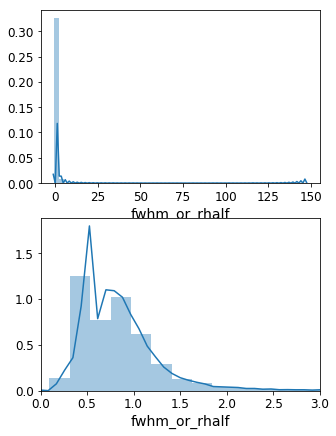

In [100]:
fig,ax= plt.subplots(2,1,figsize=(5,7))
sns.distplot(df['fwhm_or_rhalf'],ax=ax[0])
isSmall= (df['fwhm_or_rhalf'] < 10).values
sns.distplot(df.loc[isSmall,'fwhm_or_rhalf'],ax=ax[1])
ax[1].set_xlim(0,3)

(0, 3)

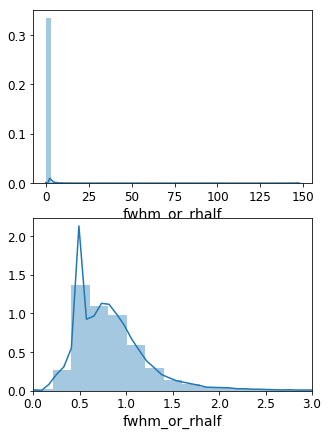

In [101]:
df= df[~isCOMP]

fig,ax= plt.subplots(2,1,figsize=(5,7))
sns.distplot(df['fwhm_or_rhalf'],ax=ax[0])
isSmall= (df['fwhm_or_rhalf'] < 10).values
sns.distplot(df.loc[isSmall,'fwhm_or_rhalf'],ax=ax[1])
ax[1].set_xlim(0,3)

IndexError: list index out of range

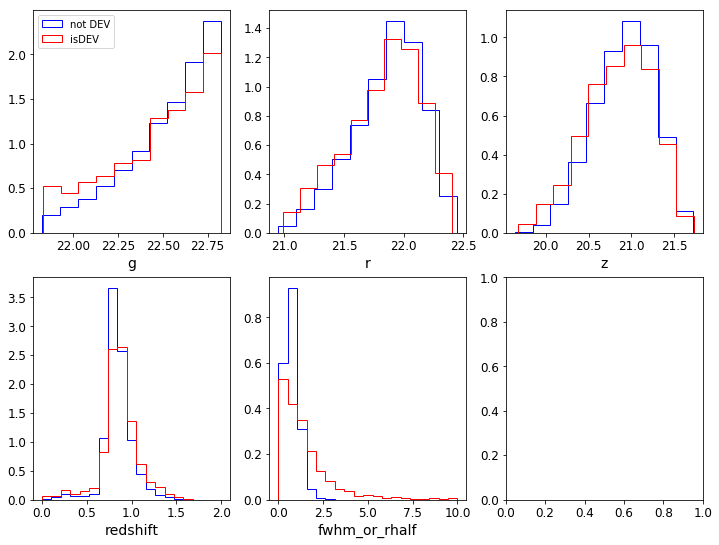

In [104]:
isDEV= (df['type'].str.strip() == 'DEV').values

attrs= ['g','r','z','redshift','fwhm_or_rhalf']
fig,ax= plt.subplots(2,3,figsize=(12,9))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        bins=None
        if attrs[i] == 'redshift':
            bins=np.linspace(0,2,20)
        if attrs[i] == 'fwhm_or_rhalf':
            bins=np.linspace(0,10,20)
        _=ax[row,col].hist(df.loc[(~isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='b',bins=bins,label='not DEV')
        _=ax[row,col].hist(df.loc[(isDEV) & (isSmall),attrs[i]],histtype='step',normed=True,
                           color='r',bins=bins,label='isDEV')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend(loc='upper left')
ax[1,1].set_xlim(0,2)

print('fraction NOT dev: ',df[~isDEV].shape[0]/df.shape[0])
print('fraction dev: ',df[isDEV].shape[0]/df.shape[0])

In [10]:
a.get_columns()

['brickname',
 'objid',
 'brick_primary',
 'tycho2inblob',
 'type',
 'ra',
 'dec',
 'ra_ivar',
 'dec_ivar',
 'dchisq',
 'ebv',
 'decam_flux',
 'decam_flux_ivar',
 'decam_apflux',
 'decam_apflux_resid',
 'decam_apflux_ivar',
 'decam_mw_transmission',
 'decam_nobs',
 'decam_rchi2',
 'decam_fracflux',
 'decam_fracmasked',
 'decam_fracin',
 'decam_anymask',
 'decam_allmask',
 'decam_psfsize',
 'wise_flux',
 'wise_flux_ivar',
 'wise_mw_transmission',
 'wise_nobs',
 'wise_fracflux',
 'wise_rchi2',
 'fracdev',
 'fracdev_ivar',
 'shapeexp_r',
 'shapeexp_r_ivar',
 'shapeexp_e1',
 'shapeexp_e1_ivar',
 'shapeexp_e2',
 'shapeexp_e2_ivar',
 'shapedev_r',
 'shapedev_r_ivar',
 'shapedev_e1',
 'shapedev_e1_ivar',
 'shapedev_e2',
 'shapedev_e2_ivar',
 'depth_ivar_g',
 'depth_ivar_r',
 'depth_ivar_z',
 'plate',
 'mjd',
 'fiberid',
 'z',
 'z_zq',
 'z_zcont',
 'z_flag']

# DR5

In [87]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr5_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/decals-dr5.0-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr5.0/trimmed/deep2-field*-trim.fits'))                                                               
print(dr5_fns,dp2_fns)

dr5= stack_tables(dr5_fns)
dp2= stack_tables(dp2_fns)

['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr5.0/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Converted wise_coadd_id from |S8 to <U8
Stacking /Users/kaylan1/Downloads/truth/dr5.0/trimmed/decals-dr5.0-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted typ

In [88]:
grz_gt0= ((dr5.flux_g > 0) &
          (dr5.flux_r > 0) &
          (dr5.flux_z > 0) &
          (dr5.flux_ivar_g > 0) &
          (dr5.flux_ivar_r > 0) &
          (dr5.flux_ivar_z > 0))
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr5))-1 # arcsec
isPSF= np.char.strip(dr5.type) == 'PSF'
isEXP= pd.Series(np.char.strip(dr5.type)).isin(['EXP','REX'])
isSIMP= np.char.strip(dr5.type) == 'SIMP'
isDEV= np.char.strip(dr5.type) == 'DEV'
isCOMP= np.char.strip(dr5.type) == 'COMP'
# rhalf ~ fwhm/2
fwhm_or_rhalf[isPSF]= np.mean(np.array([dr5[isPSF].psfsize_g,
                                        dr5[isPSF].psfsize_r,
                                        dr5[isPSF].psfsize_z]),axis=0)/2
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr5[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr5[isDEV].shapedev_r
dr5.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr5),len(dp2))
print(len(dr5[grz_gt0]), len(dr5[isDEV]), len(dr5[isCOMP]))
print(len(dr5[fwhm_or_rhalf < 5]),len(dr5[complDP2_buff]))

print(set(dr5.type))
print(pd.Series(dr5.type).value_counts()/len(dr5))

28300 28300
27707 769 78
28283 23211
{'COMP', 'DEV', 'REX', 'PSF', 'EXP'}
REX     0.506325
PSF     0.324912
EXP     0.138834
DEV     0.027173
COMP    0.002756
dtype: float64


In [89]:
keep= ((grz_gt0) & 
       (isCOMP == False) &
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr5.cut(keep)
dp2.cut(keep)
len(dr5)



22705

In [110]:
d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr5.get('flux_'+b)/dr5.get('mw_transmission_'+b))
    #d[b+'_ivar']= flux2mag(dr5.get('decam_flux_ivar')[:,i]/dr5.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr5.fwhm_or_rhalf
d['type']= dr5.get('type')
df= pd.DataFrame(d)
df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

# TS box
pad= get_ELG_box(df['r-z'].values,df['g-r'].values,pad=0.5)
inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5) & 
        (df['r-z'] <= 1.6 + 0.5))

# separate out DEV, important galaxy type but in minority for Deep 2
isDEV= df['type'] == 'DEV'
print(df.loc[isDEV,'type'].value_counts())
print(df.loc[isDEV == False,'type'].value_counts())

DEV    654
Name: type, dtype: int64
REX    12046
PSF     6621
EXP     3384
Name: type, dtype: int64


(-0.6, 2.2)

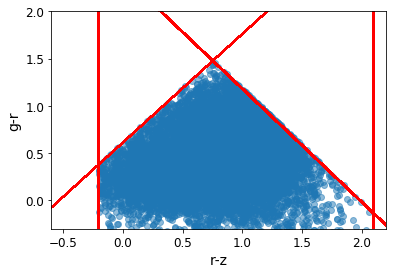

In [111]:
fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],'r--')
ax.plot(pad['x2'],pad['y2'],c='r',ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c='r',ls='--',lw=2)
ax.plot(pad['x4'],pad['y4'],c='r',ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

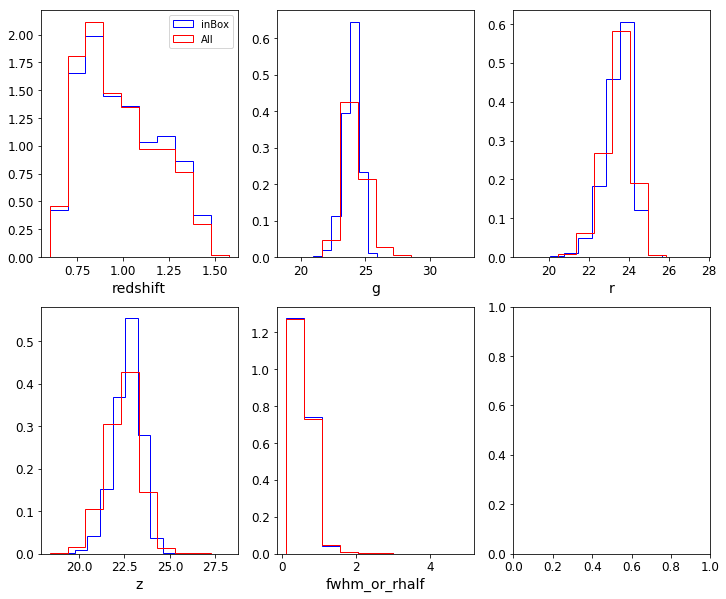

In [112]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()

## DEV have larger rhalf and are 1 mag brighter, however this is a small DEV sample so not sure if biased

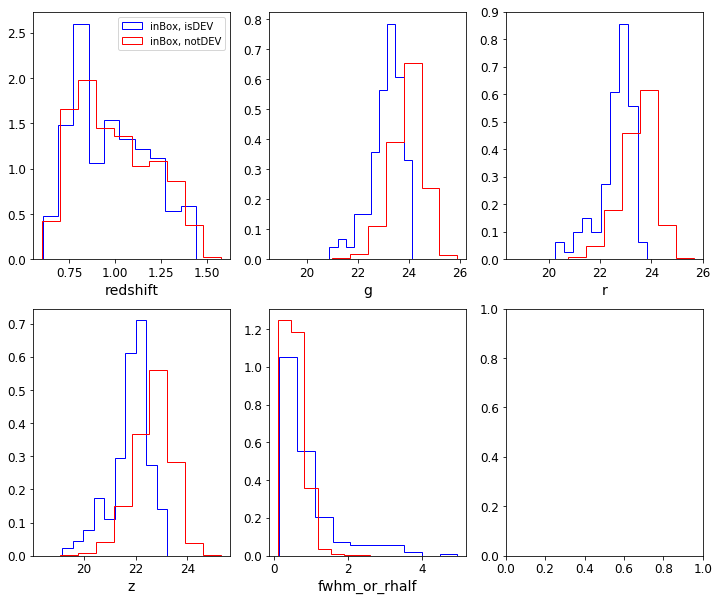

In [113]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[(inBox) & (isDEV),attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox, isDEV')
        _=ax[row,col].hist(df.loc[(inBox) & (~isDEV),attrs[i]],histtype='step',normed=True,
                           color='r',label='inBox, notDEV')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128365a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126857f60>]], dtype=object)

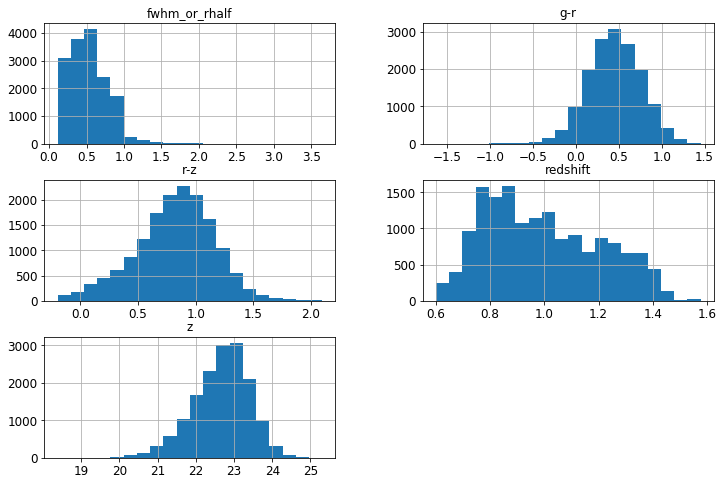

In [160]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_dev= df.loc[(inBox) & (isDEV),fit_cols]
df_notdev= df.loc[(inBox) & (~isDEV),fit_cols]
# Carry on with NOT DEV
df_notdev.hist(bins=20,figsize=(12,8))

14 components


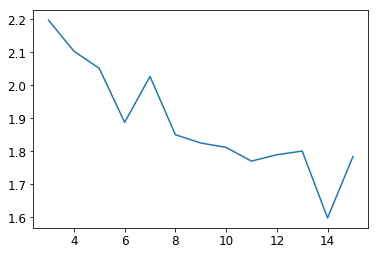

In [115]:
X= df_notdev.values
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

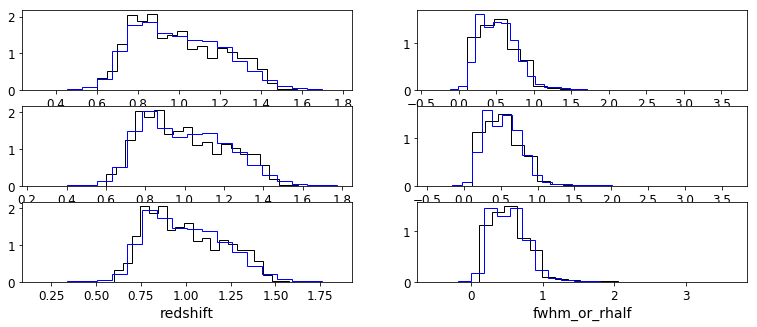

In [120]:
fig,ax= plt.subplots(3,2,figsize=(13,5))

for row,n in enumerate([8,10,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_notdev['redshift'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=20,histtype='step',color='b',normed=True)
    #ax[1].set_xlabel('redshift')

    _,bins,_= ax[row,1].hist(df_notdev['fwhm_or_rhalf'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,0],bins=20,histtype='step',color='b',normed=True)
    #ax[2].set_xlabel('fwhm_or_rhalf')
    
ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')

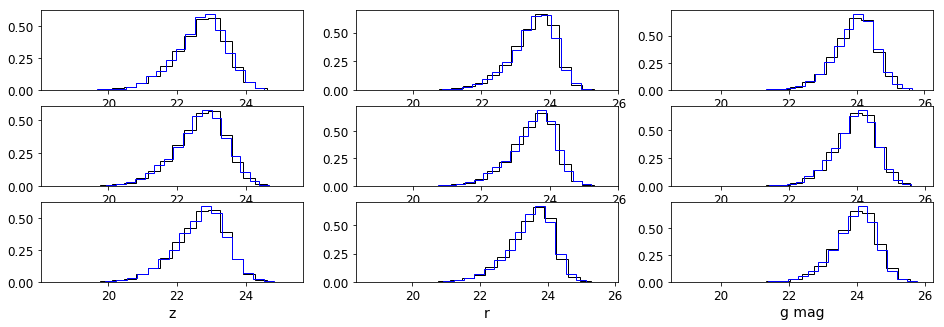

In [121]:
fig,ax= plt.subplots(3,3,figsize=(16,5))

for row,n in enumerate([8,10,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,1].hist(df_notdev['r-z']+df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,-3]+Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,2].hist(df_notdev['g-r'] + df_notdev['r-z']+df_notdev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,2].hist(Xpred[:,-4] + Xpred[:,-3] + Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)
    
ax[2,0].set_xlabel('z')
ax[2,1].set_xlabel('r')
ax[2,2].set_xlabel('g')

In [117]:
# smallest n_comp feel is ok, don't overfit!
gmm= gmms[np.where(n_comp == 8)[0][0]]
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)

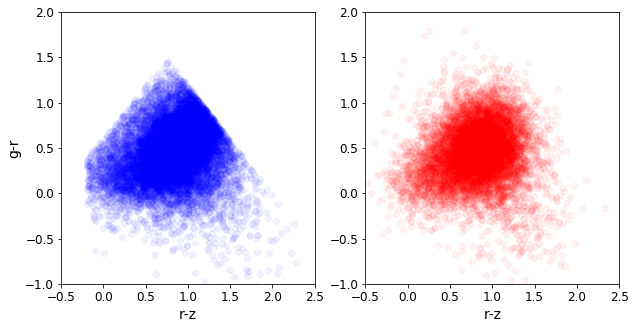

In [77]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_notdev['r-z'],df_notdev['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

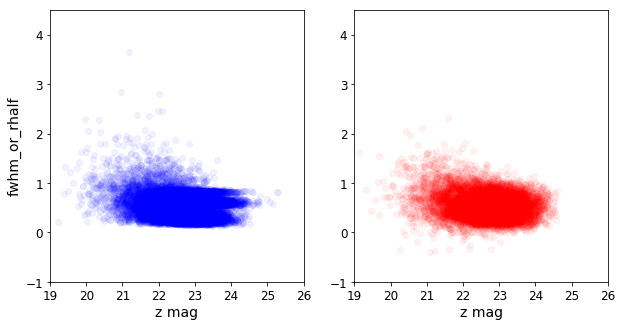

In [79]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_notdev['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)

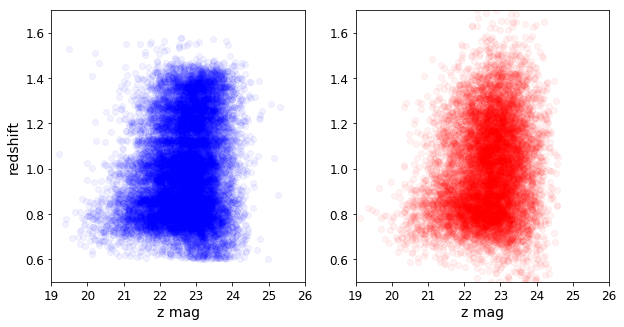

In [80]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_notdev['z'],df_notdev['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)

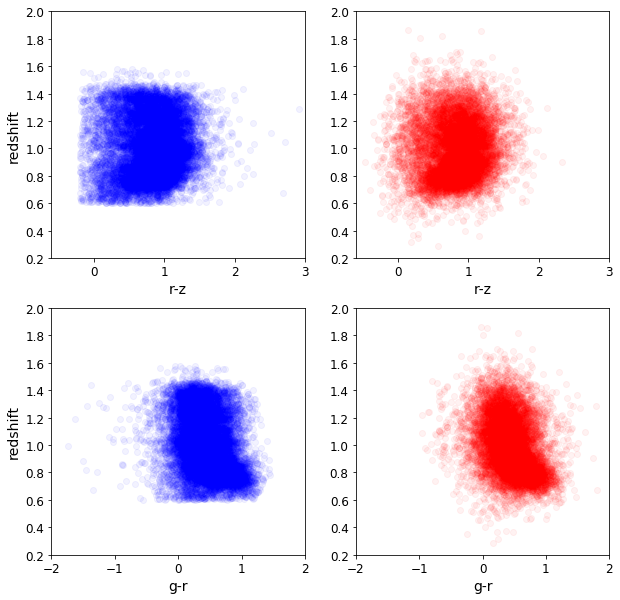

In [94]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_notdev['r-z'],df_notdev['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_notdev['g-r'],df_notdev['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')

count    15919.000000
mean         0.537243
std          0.271235
min          0.113250
25%          0.320844
50%          0.536520
75%          0.678899
max          4.954905
Name: fwhm_or_rhalf, dtype: float64

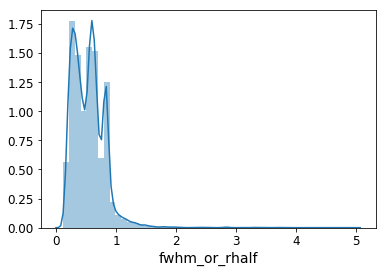

In [96]:
sns.distplot(df_new['fwhm_or_rhalf'])
df_new['fwhm_or_rhalf'].describe()

In [97]:
print(fit_cols)

['fwhm_or_rhalf', 'g-r', 'r-z', 'z', 'redshift']


## Resample until have 10k within redshift and rhalf limits

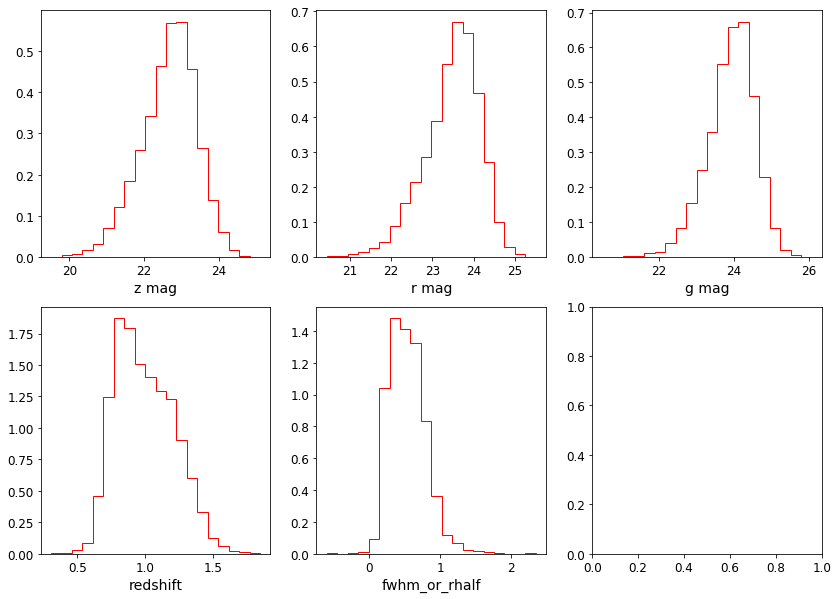

In [124]:
Xpred,Ypred= gmm.sample(10000)

fig,ax= plt.subplots(2,3,figsize=(14,10))

_=ax[0,0].hist(Xpred[:,3],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_=ax[0,1].hist(np.sum(Xpred[:,2:3+1],axis=1),bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_=ax[0,2].hist(np.sum(Xpred[:,1:3+1],axis=1),bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')

_=ax[1,0].hist(Xpred[:,-1],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('redshift')

_=ax[1,1].hist(Xpred[:,0],bins=20,histtype='step',color='r',normed=True)
ax[1,1].set_xlabel('fwhm_or_rhalf')

In [133]:
def ELGcuts(Xpred):
    """
    Args:
        Xpred: (N,5) array-like
            5 columns are: 
            fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
    """
    red_lim= (0.6,1.6) # DESI
    rhalf_lim= (0.262/2,2.) # Camera, Data
    g,r,z= tuple(np.array([24.0,23.4,22.5])+0.5)
    return ((Xpred[:,0] < rhalf_lim[0]) |
            (Xpred[:,0] > rhalf_lim[1]) |
            (Xpred[:,-1] < red_lim[0]) |
            (Xpred[:,-1] > red_lim[1]) |
            (Xpred[:,3] >= z) | #beyond mag limit
            (np.sum(Xpred[:,2:3+1],axis=1) >= r) |
            (np.sum(Xpred[:,1:3+1],axis=1) >= g)
            )

Xpred,Ypred= gmm.sample(10000)
i=0
outLimit= ELGcuts(Xpred)
num= len(Ypred[outLimit])
while num > 0:
    i+=1
    if i > 20:
        raise ValueError
    print(num)
    Xpred[outLimit,:],Ypred[outLimit]= gmm.sample(num)
    outLimit= ELGcuts(Xpred)
    num= len(Ypred[outLimit])

4345
1934
881
382
177
88
39
17
7
3
1
1
1


In [134]:
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_fin= pd.DataFrame(d)

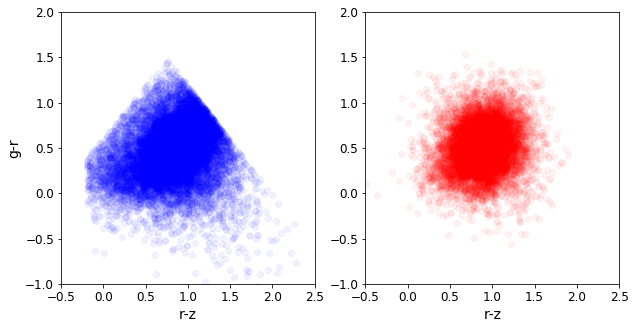

In [135]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_fin['r-z'],df_fin['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')

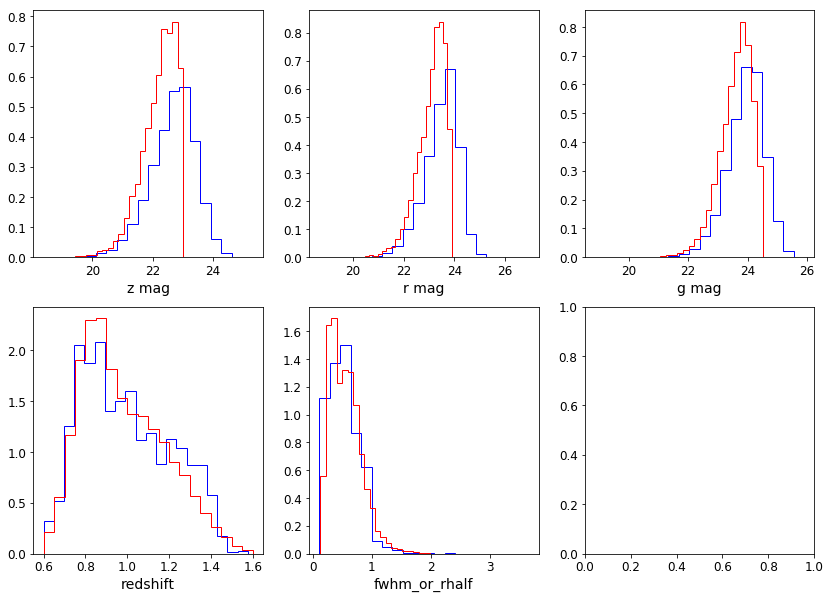

In [137]:
fig,ax= plt.subplots(2,3,figsize=(14,10))

_,bins,_= ax[0,0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,0].hist(df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,0].set_xlabel('z mag')

_,bins,_= ax[0,1].hist(df_new['r-z']+df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,1].hist(df_fin['r-z']+df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,1].set_xlabel('r mag')

_,bins,_= ax[0,2].hist(df_new['g-r']+df_new['r-z']+df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0,2].hist(df_fin['g-r']+df_fin['r-z']+df_fin['z'],bins=20,histtype='step',color='r',normed=True)
ax[0,2].set_xlabel('g mag')


_,bins,_= ax[1,0].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1,0].hist(df_fin['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1,0].set_xlabel('redshift')

_,bins,_= ax[1,1].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[1,1].hist(df_fin['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[1,1].set_xlabel('fwhm_or_rhalf')

### Save the sample

In [138]:
df_fin.columns
a=fits_table()
a.set('id',np.arange(len(df_fin)))
a.set('rhalf',df_fin['fwhm_or_rhalf'].values)
a.set('redshift',df_fin['redshift'].values)
a.set('z',df_fin['z'].values)
a.set('r',df_fin['r-z'].values + a.z)
a.set('g',df_fin['g-r'].values + a.r)
a.writeto('elg_sample_5dim_10k.fits')

# Repeat for DEV
# Conclusion: not big enough DEV sample to extrapolate from OR fit MoG to

Training Size= 225
2 components


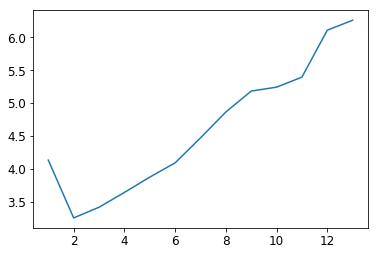

In [170]:
X= df_dev.values
print('Training Size=',X.shape[0])
gmms,i_min, n_comp, BICs= my_mixture(X,n_comp=np.arange(1,14))
plt.plot(n_comp,BICs)

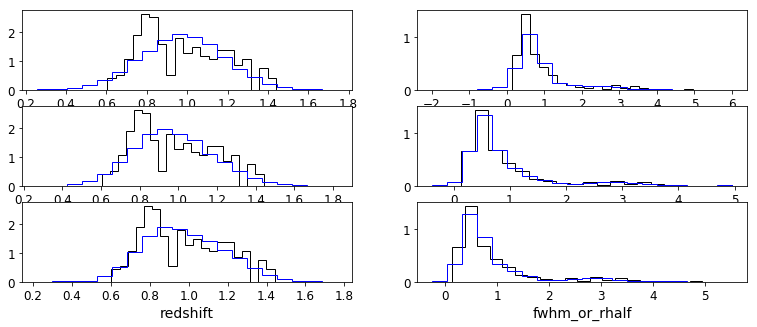

In [174]:
fig,ax= plt.subplots(3,2,figsize=(13,5))

for row,n in enumerate([2,6,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_dev['redshift'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-1],bins=20,histtype='step',color='b',normed=True)
    #ax[1].set_xlabel('redshift')

    _,bins,_= ax[row,1].hist(df_dev['fwhm_or_rhalf'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,0],bins=20,histtype='step',color='b',normed=True)
    #ax[2].set_xlabel('fwhm_or_rhalf')
    
ax[2,0].set_xlabel('redshift')
ax[2,1].set_xlabel('fwhm_or_rhalf')

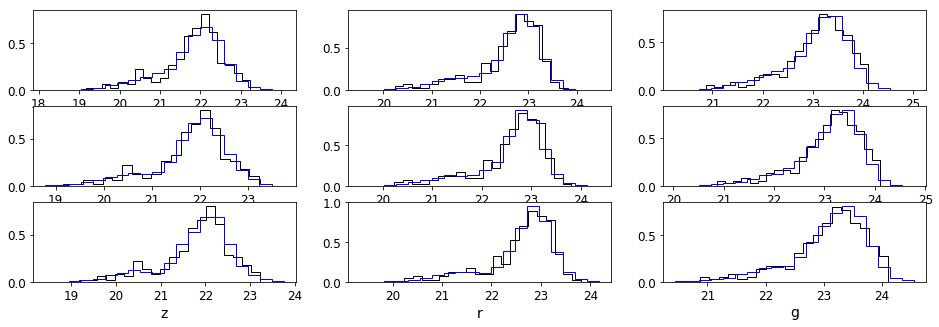

In [175]:
fig,ax= plt.subplots(3,3,figsize=(16,5))

for row,n in enumerate([2,6,10]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _,bins,_= ax[row,0].hist(df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,0].hist(Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,1].hist(df_dev['r-z']+df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,1].hist(Xpred[:,-3]+Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)

    _,bins,_= ax[row,2].hist(df_dev['g-r'] + df_dev['r-z']+df_dev['z'],bins=20,histtype='step',color='k',normed=True)
    _=ax[row,2].hist(Xpred[:,-4] + Xpred[:,-3] + Xpred[:,-2],bins=20,histtype='step',color='b',normed=True)
    
ax[2,0].set_xlabel('z')
ax[2,1].set_xlabel('r')
ax[2,2].set_xlabel('g')

# MoG to n(z) DESI

In [232]:
# random draws w/out replacement from sanches & kirkby n(z)
z1e5= fits_table(os.path.join(DATA_DIR,'sanchez_kirkby_z1e5.fits'))

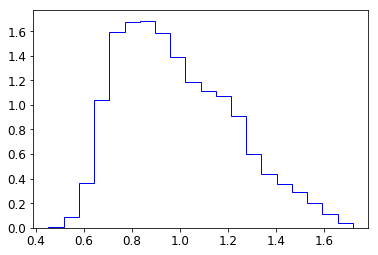

In [233]:
_=plt.hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)


4 components


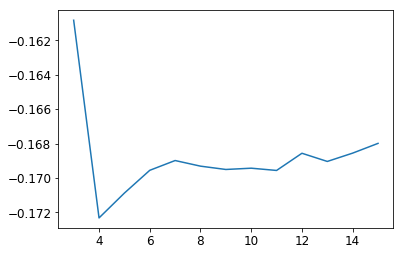

In [234]:
X= z1e5.z_cosmo.reshape(-1,1)
gmms,i_min, n_comp, BICs= my_mixture(X)
plt.plot(n_comp,BICs)

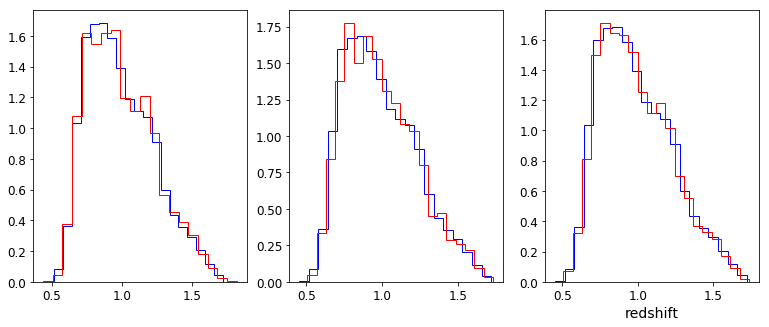

In [235]:
fig,ax= plt.subplots(1,3,figsize=(13,5))

for col,n in enumerate([4,8,12]):
    i= np.where(n_comp == n)[0][0]
    Xpred,Ypred= gmms[i].sample(10000)
    _=ax[col].hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)
    _=ax[col].hist(Xpred,bins=20,histtype='step',color='r',normed=True)
    
ax[2].set_xlabel('redshift')

## Intentionally overfit n(z)

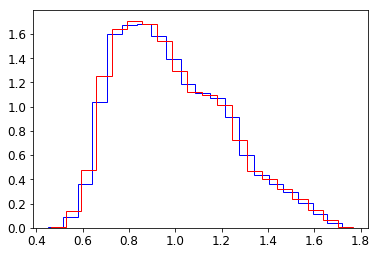

In [236]:
gmm= gmms[12]
z_pred,pdf_pred= gmm.sample(100000)
_=plt.hist(z1e5.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=plt.hist(z_pred,bins=20,histtype='step',color='r',normed=True)

### Save model

In [290]:
np.arange(10).reshape(-1,1,1).shape

(10, 1, 1)

In [8]:
class GaussianMixtureModel(object):
    """
    John's class to read, write, and sample from a mixture model.
    
    Args: 
        weights,means,covars: array-like, from mixture fit
        covar_type: usually 'full'
        py: one of ['27','36']
    """
    def __init__(self, weights, means, covars, 
                 py=None,covar_type='full',is1D=False):
        assert(py in ['27','36'])
        self.py= py
        self.is1D= is1D
        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covars
        if self.is1D:
            self.weights_ = self.weights_.reshape(-1,1)
            self.means_ = self.means_.reshape(-1,1)
            self.covariances_ = self.covariances_.reshape(-1,1,1)
        #    self.n_components, self.n_dimensions = self.means_.shape[0],1
        #else:
        self.n_components, self.n_dimensions = self.means_.shape
        #print(self.weights_.shape,self.covariances_.shape,len(self.covariances_.shape))
        self.covariance_type= covar_type
    
    @staticmethod
    def save(model, filename):
        for name,data in zip(['means','weights','covars'],
                     [model.means_, model.weights_,
                      model.covariances_]):
            fn= '%s_%s.txt' % (filename,name)
            np.savetxt(fn,data,delimiter=',')
            print('Wrote %s' % fn)

    @staticmethod
    def load(filename,py=None,is1D=False):
        d={name:np.loadtxt('%s_%s.txt' % (filename,name),delimiter=',')
           for name in ['means','weights','covars']}
        return GaussianMixtureModel(
                    d['weights'],d['means'],d['covars'],
                    covar_type='full',py=py,is1D=is1D)
    
    def sample(self, n_samples=1, random_state=None):
        assert(n_samples >= 1)
        self.n_samples= n_samples
        if random_state is None:
            random_state = np.random.RandomState()
        self.rng= random_state
        
        if self.py == '2.7':
            X= self.sample_py2()
        else:
            X,Y= self.sample_py3()
        return X
    
    def sample_py2(self):
        weight_cdf = np.cumsum(self.weights_)
        X = np.empty((self.n_samples, self.n_components))
        rand = self.rng.rand(self.n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = self.rng.multivariate_normal(
                    self.means_[comp], self.covariances_[comp], num_comp_in_X)
        return X
    
    def sample_py3(self):
        """Copied from sklearn's mixture.GaussianMixture().sample()"""
        print(self.weights_.shape)
        try:
            n_samples_comp = self.rng.multinomial(self.n_samples, self.weights_)
        except ValueError:
            self.weights_= np.reshape(self.weights_,len(self.weights_))
            n_samples_comp = self.rng.multinomial(self.n_samples, self.weights_)
        if self.covariance_type == 'full':
            X = np.vstack([
                self.rng.multivariate_normal(mean, covariance, int(sample))
                for (mean, covariance, sample) in zip(
                    self.means_, self.covariances_, n_samples_comp)])
        elif self.covariance_type == "tied":
            X = np.vstack([
                self.rng.multivariate_normal(mean, self.covariances_, int(sample))
                for (mean, sample) in zip(
                    self.means_, n_samples_comp)])
        else:
            X = np.vstack([
                mean + self.rng.randn(sample, n_features) * np.sqrt(covariance)
                for (mean, covariance, sample) in zip(
                    self.means_, self.covariances_, n_samples_comp)])

        y = np.concatenate([j * np.ones(sample, dtype=int)
                           for j, sample in enumerate(n_samples_comp)])

        return (X, y)


In [239]:
GaussianMixtureModel.save(gmm, filename='elg_nz', py='36')

Wrote elg_nz_means_36.txt
Wrote elg_nz_weights_36.txt
Wrote elg_nz_covars_36.txt


## Draw from n(z), match to 10k dr3-deep2 sample, plot redshift distribution of new dr3-deep2-nz sample

In [5]:
from scipy import spatial
sample_5d_10k=fits_table('elg_sample_5dim_10k.fits')
from obiwan.common import fits2pandas
sample_5d_10k= fits2pandas(sample_5d_10k)

tree = spatial.KDTree(sample_5d_10k['redshift'].values.reshape(-1,1))

In [253]:
gmm.covariances_.shape

(15, 1, 1)

In [9]:
model= GaussianMixtureModel.load(filename='elg_nz',py='36',is1D=True)

In [13]:
z= model.sample(1000)
_,ind= tree.query(z)
randoms= sample_5d_10k.iloc[ind]

print(len(sample_5d_10k),len(z),len(randoms))
print(randoms.columns), print(sample_5d_10k.columns)

(15,)
10000 1000 1000
Index(['g', 'id', 'r', 'redshift', 'rhalf', 'z'], dtype='object')
Index(['g', 'id', 'r', 'redshift', 'rhalf', 'z'], dtype='object')


(None, None)

In [18]:
for i in range(10):
    print(z[i],randoms['redshift'].iloc[i])

[ 1.17863478] 1.17876047504
[ 1.17322301] 1.17322153666
[ 1.1506008] 1.15054300718
[ 1.19767244] 1.19775757811
[ 1.19893259] 1.19892718065
[ 1.15093723] 1.15096243379
[ 1.15994011] 1.15990993527
[ 1.15066201] 1.15067316369
[ 1.13602797] 1.13600715492
[ 1.15877533] 1.1587258549


In [306]:
# Randoms table 
a=fits_table()
a.set('id',np.arange(len(randoms)))
a.set('id_5d10k_sample',randoms['id'].values) 
a.set('rhalf',randoms['rhalf'].values)
a.set('redshift',randoms['redshift'].values)
a.set('z',randoms['z'].values)
a.set('r',randoms['r'].values)
a.set('g',randoms['g'].values)
a.writeto('randoms_1.fits')

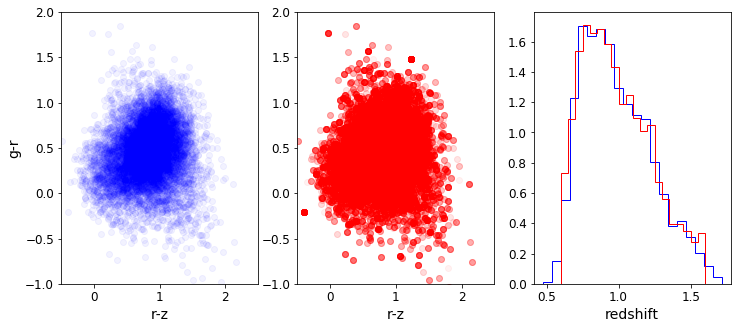

In [139]:
fig,ax= plt.subplots(1,3,figsize=(12,5))
ax[0].scatter(df_fin['r-z'],df_fin['g-r'],color='b',alpha=0.05)
ax[1].scatter(randoms['r-z'],randoms['g-r'],color='r',alpha=0.05)
_=ax[2].hist(z_10k.z_cosmo,bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(randoms['redshift'],bins=20,histtype='step',color='r',normed=True)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')
ax[2].set_xlabel('redshift')

## Fraction 10k sample in ELG TS box

In [8]:
tenk= fits_table('../../etc/elg_sample_5dim_10k.fits')

0.4201


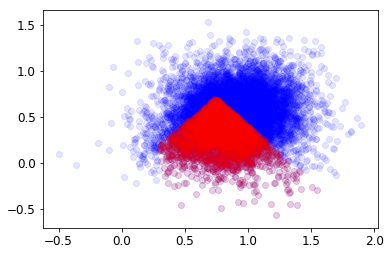

In [14]:
gr= tenk.g - tenk.r
rz= tenk.r - tenk.z
inBox= ((gr <= y1_line(rz)) &
        (gr <= y2_line(rz)) & 
        (rz >= 0.3) & 
        (rz <= 1.6))
plt.scatter(rz,gr,color='b',alpha=0.1)
plt.scatter(rz[inBox],gr[inBox],color='r',alpha=0.1)
print(len(rz[inBox])/float(len(rz)))

# eBOSS

In [17]:
DATA_DIR = os.path.join(os.environ['HOME'],'Downloads',
                        'truth')
dr3_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/decals-dr3.1-deep2-field*-trim.fits'))
dp2_fns= glob(os.path.join(DATA_DIR,
                'dr3.1/trimmed/deep2-field*-trim.fits'))                                                                                                                             
print(dr3_fns,dp2_fns)

dr3= stack_tables(dr3_fns)
dp2= stack_tables(dp2_fns)


['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits'] ['/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field2-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field3-trim.fits', '/Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-field4-trim.fits']
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field2-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field3-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/decals-dr3.1-deep2-field4-trim.fits
Converted brickname from |S8 to <U8
Converted type from |S4 to <U4
Stacking /Users/kaylan1/Downloads/truth/dr3.1/trimmed/deep2-fi

In [18]:
grz_gt0= (np.all(dr3.decam_flux[:,[1,2,4]] > 0,axis=1) &
          np.all(dr3.decam_flux_ivar[:,[1,2,4]] > 0,axis=1))
notCOMP= dr3.type != 'COMP'
#redshift_gt0= dp2.zhelio > 0
complDP2_buff= ((dp2.zhelio >= 0.8-0.2) & 
                (dp2.zhelio <= 1.4+0.2))

fwhm_or_rhalf= np.zeros(len(dr3))-1 # arcsec
isPSF= np.char.strip(dr3.type) == 'PSF'
isEXP= np.char.strip(dr3.type) == 'EXP'
isSIMP= np.char.strip(dr3.type) == 'SIMP'
isDEV= np.char.strip(dr3.type) == 'DEV'
fwhm_or_rhalf[isPSF]= np.mean(dr3[isPSF].decam_psfsize[:,[1,2,4]],axis=1)
fwhm_or_rhalf[isSIMP]= 0.5
fwhm_or_rhalf[isEXP]= dr3[isEXP].shapeexp_r
fwhm_or_rhalf[isDEV]= dr3[isDEV].shapedev_r
dr3.set('fwhm_or_rhalf',fwhm_or_rhalf)

print(len(dr3),len(dp2))
print(len(dr3[grz_gt0]), len(dr3[~notCOMP]))
print(len(dr3[fwhm_or_rhalf < 5]),len(dr3[complDP2_buff]))

print(set(dr3.type))
print(pd.Series(dr3.type).value_counts()/len(dr3))



28284 28284
27433 76
28265 23212
{'COMP', 'DEV', 'SIMP', 'EXP', 'PSF'}
PSF     0.440815
SIMP    0.335349
EXP     0.184557
DEV     0.036593
COMP    0.002687
dtype: float64


In [19]:
keep= ((grz_gt0) & 
       (notCOMP) & 
       (fwhm_or_rhalf < 5) & 
       (complDP2_buff)) 
dr3.cut(keep)
dp2.cut(keep)
len(dr3)


d= {}
for i,b in zip([1,2,4],'grz'):
    d[b]= flux2mag(dr3.get('decam_flux')[:,i]/dr3.get('decam_mw_transmission')[:,i])
    #d[b+'_ivar']= flux2mag(dr3.get('decam_flux_ivar')[:,i]/dr3.get('decam_mw_transmission')[:,i])  
d['redshift']= dp2.get('zhelio')
d['fwhm_or_rhalf']= dr3.fwhm_or_rhalf
d['type']= dr3.get('type')
df= pd.DataFrame(d)

df['g-r']= df['g'] - df['r']
df['r-z']= df['r'] - df['z']

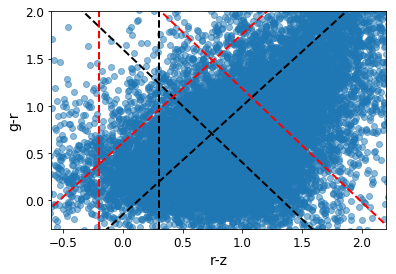

In [21]:
fig,ax=plt.subplots()
ax.scatter(df['r-z'],df['g-r'],alpha=0.5)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)

rz= np.linspace(ax.get_xlim()[0],ax.get_xlim()[1])
gr= np.linspace(ax.get_ylim()[0],ax.get_ylim()[1])
nopad= get_ELG_box(rz,gr)
pad= get_ELG_box(rz,gr,pad=0.5)
for d,color in zip([nopad,pad],['k','r']):
    ax.plot(d['x1'],d['y1'],c=color,ls='--',lw=2)
    ax.plot(d['x2'],d['y2'],c=color,ls='--',lw=2)
    ax.plot(d['x3'],d['y3'],c=color,ls='--',lw=2)


(-0.6, 2.2)

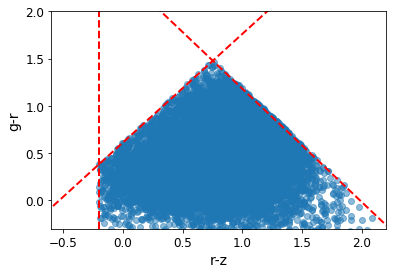

In [22]:
inBox= ((df['g-r'] <= y1_line(df['r-z'],pad=0.5)) &
        (df['g-r'] <= y2_line(df['r-z'],pad=0.5)) & 
        (df['r-z'] >= 0.3 - 0.5))

fig,ax=plt.subplots()
ax.scatter(df.loc[inBox,'r-z'], df.loc[inBox,'g-r'],alpha=0.5)
ax.plot(pad['x1'],pad['y1'],c=color,ls='--',lw=2)
ax.plot(pad['x2'],pad['y2'],c=color,ls='--',lw=2)
ax.plot(pad['x3'],pad['y3'],c=color,ls='--',lw=2)
ax.set_xlabel('r-z')
ax.set_ylabel('g-r')
ax.set_ylim(-0.3,2)
ax.set_xlim(-0.6,2.2)



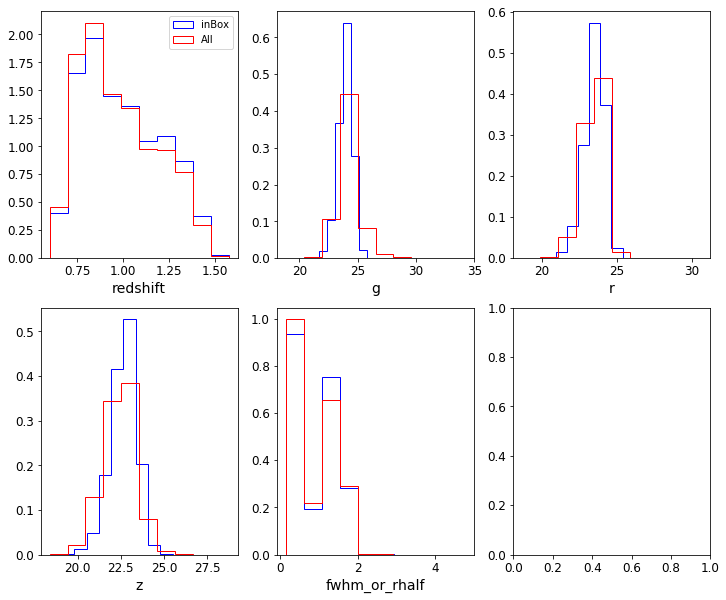

In [24]:
attrs= ['redshift','g','r','z','fwhm_or_rhalf']

fig,ax= plt.subplots(2,3,figsize=(12,10))
i=-1
for row in range(2):
    for col in range(3):
        i+=1
        if i >= len(attrs):
            continue
        _=ax[row,col].hist(df.loc[inBox,attrs[i]],histtype='step',normed=True,
                           color='b',label='inBox')
        _=ax[row,col].hist(df[attrs[i]],histtype='step',normed=True,
                           color='r',label='All')
        ax[row,col].set_xlabel(attrs[i])
        if i == 0:
            ax[row,col].legend()



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117116ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1152b2eb8>]], dtype=object)

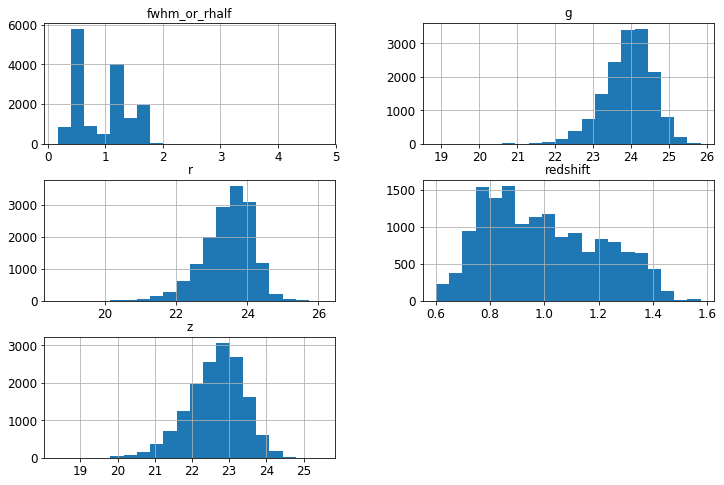

In [25]:
cols=['fwhm_or_rhalf', 'g', 'r', 'redshift', 'z']
df.loc[inBox,cols].hist(bins=20,figsize=(12,8))



14 components


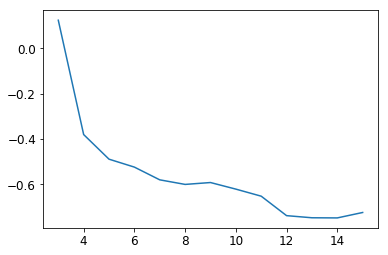

In [30]:
fit_cols= ['fwhm_or_rhalf', 'g-r', 'r-z','z','redshift']
df_new= df.loc[inBox,fit_cols]

X= df_new.values
gmm, n_comp, BICs= my_mixture(X)
logprob= gmm.score_samples(X)
responsibilities = gmm.predict_proba(X)

plt.plot(n_comp,BICs)



In [31]:
Xpred,Ypred= gmm.sample(10000)
d={}
for i,col in enumerate(fit_cols):
    d[col]= Xpred[:,i]
df_pred= pd.DataFrame(d)





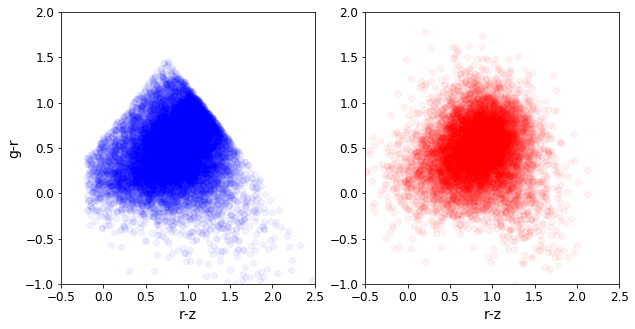

In [32]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['r-z'],df_new['g-r'],color='b',alpha=0.05)
ax[1].scatter(df_pred['r-z'],df_pred['g-r'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('r-z')
    ax[i].set_xlim(-0.5,2.5)
    ax[i].set_ylim(-1,2)
ax[0].set_ylabel('g-r')



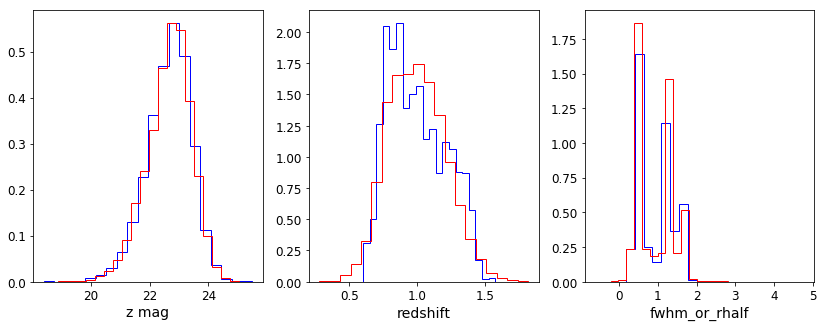

In [34]:
fig,ax= plt.subplots(1,3,figsize=(14,5))

_,bins,_= ax[0].hist(df_new['z'],bins=20,histtype='step',color='b',normed=True)
_=ax[0].hist(df_pred['z'],bins=20,histtype='step',color='r',normed=True)
ax[0].set_xlabel('z mag')

_,bins,_= ax[1].hist(df_new['redshift'],bins=20,histtype='step',color='b',normed=True)
_=ax[1].hist(df_pred['redshift'],bins=20,histtype='step',color='r',normed=True)
ax[1].set_xlabel('redshift')

_,bins,_= ax[2].hist(df_new['fwhm_or_rhalf'],bins=20,histtype='step',color='b',normed=True)
_=ax[2].hist(df_pred['fwhm_or_rhalf'],bins=20,histtype='step',color='r',normed=True)
ax[2].set_xlabel('fwhm_or_rhalf')



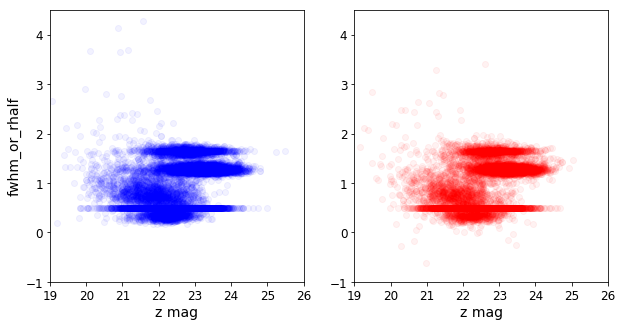

In [35]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['fwhm_or_rhalf'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['fwhm_or_rhalf'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('fwhm_or_rhalf')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(-1,4.5)



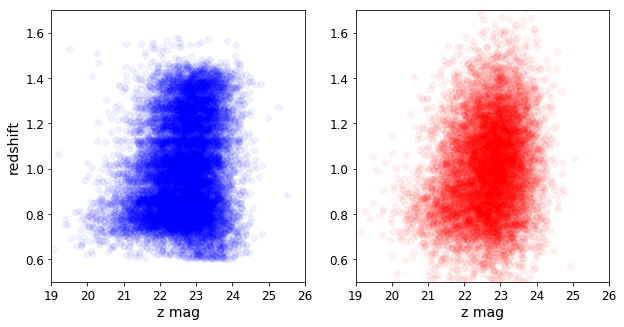

In [36]:
fig,ax= plt.subplots(1,2,figsize=(10,5))
ax[0].scatter(df_new['z'],df_new['redshift'],color='b',alpha=0.05)
ax[1].scatter(df_pred['z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[i].set_xlabel('z mag')
ax[0].set_ylabel('redshift')
for i in range(2):
    ax[i].set_xlim(19,26)
    ax[i].set_ylim(0.5,1.7)



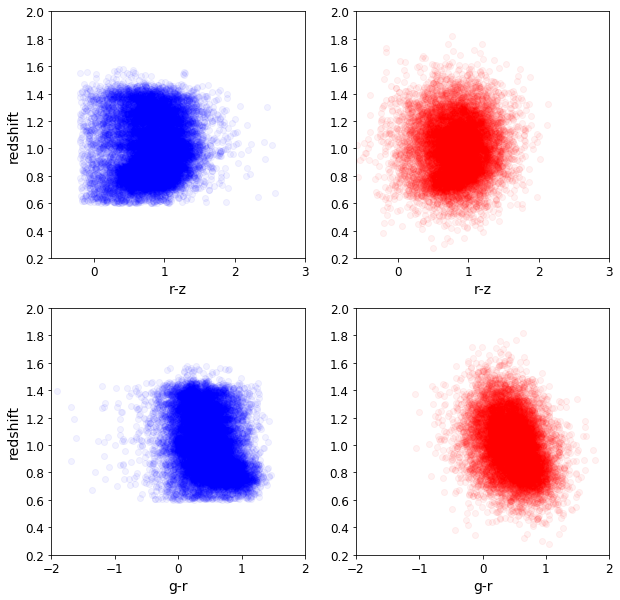

In [37]:
fig,ax= plt.subplots(2,2,figsize=(10,10))
ax[0,0].scatter(df_new['r-z'],df_new['redshift'],color='b',alpha=0.05)
ax[0,1].scatter(df_pred['r-z'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[0,i].set_xlabel('r-z')
    ax[0,i].set_xlim(-0.6,3)
    ax[0,i].set_ylim(0.2,2)
    
ax[1,0].scatter(df_new['g-r'],df_new['redshift'],color='b',alpha=0.05)
ax[1,1].scatter(df_pred['g-r'],df_pred['redshift'],color='r',alpha=0.05)
for i in range(2):
    ax[1,i].set_xlabel('g-r')
    ax[1,i].set_xlim(-2,2)
    ax[1,i].set_ylim(0.2,2)
    
for i in range(2):
    ax[i,0].set_ylabel('redshift')